# NB05: Prioritization & Candidate Dossiers

**No Spark required** — this notebook uses only local pandas on outputs from NB01–NB04.

## Purpose

Score, rank, and produce experimental prioritization for functional dark matter genes.
Multi-dimensional scoring across 6 evidence axes:

1. **Fitness importance** (0.25): max |fitness|, # specific phenotypes, essentiality
2. **Cross-organism conservation** (0.20): # FB organisms with ortholog, concordance score
3. **Functional inference quality** (0.20): module membership, co-fitness, domains, GapMind
4. **Pangenome distribution** (0.15): phylogenetic breadth, core/accessory
5. **Biogeographic signal** (0.10): environmental pattern, lab-field concordance
6. **Experimental tractability** (0.10): tractable organism, not essential, has partners

## Inputs

- `data/dark_genes_integrated.tsv` (NB01) — unified dark gene table
- `data/dark_genes_only.tsv` (NB01) — dark genes subset
- `data/gapmind_gap_candidates.tsv` (NB02) — GapMind pathway gaps
- `data/concordance_scores.tsv` (NB02) — cross-organism concordance
- `data/phylogenetic_breadth.tsv` (NB02) — pangenome distribution
- `data/carrier_noncarrier_tests.tsv` (NB03) — biogeographic tests
- `data/lab_field_concordance.tsv` (NB04) — lab-field concordance

## Outputs

- `data/prioritized_candidates.tsv` — top 100 ranked candidates
- `data/scoring_all_dark.tsv` — scores for all scored dark genes
- `figures/fig13_score_components.png`
- `figures/fig14_top20_dossiers.png`
- `figures/fig15_organism_distribution.png`

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Path setup
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()
    _d = PROJECT_DIR
    while _d != '/':
        if os.path.exists(os.path.join(_d, 'PROJECT.md')):
            break
        _d = os.path.dirname(_d)

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print(f'Project dir: {PROJECT_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter


## Section 1: Load All Data Products

In [2]:
# Load all data from NB01-NB04
dark = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_only.tsv'), sep='\t', low_memory=False)
print(f'Dark genes: {len(dark):,}')

gapmind = pd.read_csv(os.path.join(DATA_DIR, 'gapmind_gap_candidates.tsv'), sep='\t')
print(f'GapMind gap candidates: {len(gapmind):,} (organism-pathway pairs with dark genes near gaps)')

concordance = pd.read_csv(os.path.join(DATA_DIR, 'concordance_scores.tsv'), sep='\t')
print(f'Concordance scores: {len(concordance)} ortholog groups')

phylo = pd.read_csv(os.path.join(DATA_DIR, 'phylogenetic_breadth.tsv'), sep='\t')
print(f'Phylogenetic breadth: {len(phylo):,} gene clusters')

carrier_tests = pd.read_csv(os.path.join(DATA_DIR, 'carrier_noncarrier_tests.tsv'), sep='\t')
print(f'Carrier tests: {len(carrier_tests)} clusters')

lab_field = pd.read_csv(os.path.join(DATA_DIR, 'lab_field_concordance.tsv'), sep='\t')
print(f'Lab-field concordance: {len(lab_field)} clusters')

Dark genes: 57,011
GapMind gap candidates: 1,256 (organism-pathway pairs with dark genes near gaps)
Concordance scores: 65 ortholog groups
Phylogenetic breadth: 30,756 gene clusters
Carrier tests: 151 clusters
Lab-field concordance: 47 clusters


In [3]:
# Focus on dark genes with strong fitness effects (the actionable set)
# Include both: (1) strong fitness dark genes and (2) essential dark genes
strong_dark = dark[
    (dark['is_dark'] == True) &
    (
        (dark['max_abs_fit'].astype(float) >= 2.0) |
        (dark['is_essential_dark'] == True)
    )
].copy()

print(f'Dark genes with strong fitness or essential: {len(strong_dark):,}')
print(f'  Strong fitness (|fit| >= 2): {(strong_dark["max_abs_fit"].astype(float) >= 2.0).sum():,}')
print(f'  Essential dark: {(strong_dark["is_essential_dark"] == True).sum():,}')
print(f'  Organisms: {strong_dark["orgId"].nunique()}')
print(f'\nAnnotation classes:')
print(strong_dark['annotation_class'].value_counts().to_string())

Dark genes with strong fitness or essential: 17,344
  Strong fitness (|fit| >= 2): 7,787
  Essential dark: 9,557
  Organisms: 48

Annotation classes:
annotation_class
hypothetical       14430
no_annotation       1103
DUF                  915
uncharacterized      896


## Section 2: Scoring Functions

Each dimension returns a score in [0, 1]. Higher = better candidate.

In [4]:
# Scoring weights
WEIGHTS = {
    'fitness': 0.25,
    'conservation': 0.20,
    'inference': 0.20,
    'pangenome': 0.15,
    'biogeographic': 0.10,
    'tractability': 0.10,
}
assert abs(sum(WEIGHTS.values()) - 1.0) < 1e-6
print('Scoring weights:', WEIGHTS)

Scoring weights: {'fitness': 0.25, 'conservation': 0.2, 'inference': 0.2, 'pangenome': 0.15, 'biogeographic': 0.1, 'tractability': 0.1}


In [5]:
def _safe_int(val, default=0):
    """Safely convert to int, handling NaN/None."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return default
    try:
        return int(val)
    except (ValueError, TypeError):
        return default

def _safe_float(val, default=0.0):
    """Safely convert to float, handling NaN/None."""
    if val is None:
        return default
    try:
        f = float(val)
        return default if np.isnan(f) else f
    except (ValueError, TypeError):
        return default


def score_fitness(row):
    """Score fitness importance (0-1). Weight: 0.25."""
    score = 0.0
    
    # Max |fitness| contribution (0-0.5)
    max_fit = _safe_float(row.get('max_abs_fit', 0))
    # Normalize: 2 -> 0.25, 4 -> 0.5 (cap at 4)
    score += min(max_fit / 8.0, 0.5)
    
    # Number of specific phenotypes (0-0.25)
    n_sp = _safe_int(row.get('n_specific_phenotypes', 0))
    score += min(n_sp / 20.0, 0.25)
    
    # Essential bonus (0.15)
    if row.get('is_essential_dark') == True or row.get('essentiality_class') == 'essential_all':
        score += 0.15
    
    # Number of condition classes (0-0.1)
    n_cc = _safe_int(row.get('n_condition_classes', 0))
    score += min(n_cc / 10.0, 0.1)
    
    return min(score, 1.0)


def score_conservation(row, concordance_lookup):
    """Score cross-organism conservation (0-1). Weight: 0.20."""
    score = 0.0
    
    # Has ortholog in other FB organisms (0.3)
    if row.get('has_ortholog') == True:
        score += 0.3
    
    # Number of FB organisms with ortholog (0-0.3)
    n_orgs = _safe_int(row.get('og_n_organisms', 0))
    score += min(n_orgs / 48.0, 0.3) if n_orgs > 0 else 0
    
    # Cross-organism fitness concordance (0-0.4)
    og_id = str(row.get('OG_id', ''))
    if og_id and og_id != 'nan' and og_id in concordance_lookup:
        conc = concordance_lookup[og_id]
        max_conc = _safe_float(conc.get('max_concordance', 0))
        score += max_conc * 0.4
    
    return min(score, 1.0)


def score_inference(row, gapmind_org_lookup):
    """Score functional inference quality (0-1). Weight: 0.20."""
    score = 0.0
    
    # In a module with prediction (0.35)
    if row.get('in_module') == True and pd.notna(row.get('module_prediction')) and str(row.get('module_prediction', '')) not in ('', 'nan'):
        score += 0.3
    elif row.get('in_module') == True:
        score += 0.15  # In module but no prediction
    
    # Has domain annotations (0.15)
    n_domains = _safe_int(row.get('n_domains', 0))
    if n_domains > 0:
        score += 0.15
    
    # Top co-fitness score (0-0.2)
    cofit_score = _safe_float(row.get('top_cofit_score', 0))
    if cofit_score > 0:
        score += min(cofit_score / 1.0, 0.2)  # cofit typically 0-0.8
    
    # GapMind gap-filling evidence (0.2)
    org_id = row.get('orgId', '')
    if org_id in gapmind_org_lookup:
        org_gaps = gapmind_org_lookup[org_id]
        if any(_safe_int(g.get('n_dark_strong_fitness', 0)) > 0 for g in org_gaps):
            score += 0.2
        elif any(_safe_int(g.get('n_dark_genes', 0)) > 0 for g in org_gaps):
            score += 0.1
    
    # Essential prediction (0.1)
    epred = str(row.get('essential_prediction', ''))
    if epred and epred not in ('', 'nan'):
        score += 0.1
    
    return min(score, 1.0)


def score_pangenome(row, phylo_lookup):
    """Score pangenome distribution (0-1). Weight: 0.15."""
    score = 0.0
    
    # Has pangenome link (0.2)
    if row.get('has_pangenome_link') == True:
        score += 0.2
    
    # Core/accessory classification (0.3)
    if row.get('is_core') == True:
        score += 0.3  # Core genes are interesting — conserved unknown function
    elif row.get('is_auxiliary') == True:
        score += 0.2  # Accessory — may have environmental-specific role
    
    # Phylogenetic breadth (0-0.5)
    gc_id = str(row.get('gene_cluster_id', ''))
    if gc_id and gc_id != 'nan' and gc_id in phylo_lookup:
        breadth = phylo_lookup[gc_id]
        bc = str(breadth.get('breadth_class', ''))
        if bc == 'universal':
            score += 0.5
        elif bc == 'pan-bacterial':
            score += 0.4
        elif bc == 'multi-phylum':
            score += 0.3
        elif bc == 'phylum-restricted':
            score += 0.2
        elif bc == 'narrow':
            score += 0.1
    
    return min(score, 1.0)


def score_biogeographic(row, carrier_lookup, labfield_lookup):
    """Score biogeographic signal (0-1). Weight: 0.10."""
    score = 0.0
    
    gc_id = str(row.get('gene_cluster_id', ''))
    if not gc_id or gc_id == 'nan':
        return 0.0
    
    # Carrier vs non-carrier test result (0-0.5)
    if gc_id in carrier_lookup:
        ct = carrier_lookup[gc_id]
        # Significant env test
        env_fdr = _safe_float(ct.get('env_fdr', 1.0), 1.0)
        if env_fdr < 0.05:
            score += 0.5
        elif env_fdr < 0.2:
            score += 0.3
        else:
            env_p = _safe_float(ct.get('env_p_value', 1.0), 1.0)
            if env_p < 0.05:
                score += 0.15
    
    # Lab-field concordance (0-0.5)
    if gc_id in labfield_lookup:
        lf = labfield_lookup[gc_id]
        if lf.get('is_concordant') == True:
            score += 0.25
            lf_fdr = _safe_float(lf.get('fdr', 1.0), 1.0)
            if lf_fdr < 0.05:
                score += 0.25
            elif lf_fdr < 0.2:
                score += 0.15
    
    return min(score, 1.0)


# Tractable organisms (well-developed genetic tools in FB)
TRACTABLE_ORGS = {
    'Keio', 'Deshi', 'SB2B', 'Pse', 'Pseu', 'pseudo5_N2C3_1', 'pseudo3_N2E2',
    'pseudo13_GW456_L13', 'pseudo1_N1B4', 'Shew', 'Shewmr4', 'Marino',
    'MR1', 'Smeli', 'BW25113', 'Koxy', 'Acinetobacter', 'Abaumannii',
    'Synpcc7942', 'Synpcc6803', 'Rleg', 'Rpha', 'Bfrag', 'Clostridi',
    'Caulobacter', 'Geobacter', 'Sinorhizobium', 'Sphingomonas',
    'BT', 'Bacteroides_theta',
}


def score_tractability(row):
    """Score experimental tractability (0-1). Weight: 0.10."""
    score = 0.0
    
    # In a tractable organism (0.4)
    org = row.get('orgId', '')
    if org in TRACTABLE_ORGS:
        score += 0.4
    
    # Not essential (can make knockouts) (0.3)
    if row.get('is_essential_dark') != True and row.get('essentiality_class') != 'essential_all':
        score += 0.3
    else:
        score += 0.1  # Essential genes are harder to study but important
    
    # Has characterized co-fitness partners (0.15)
    partners = str(row.get('top_cofit_partners', ''))
    if partners and partners not in ('nan', ''):
        score += 0.15
    
    # Has specific phenotype (clear experimental lead) (0.15)
    n_sp = _safe_int(row.get('n_specific_phenotypes', 0))
    if n_sp > 0:
        score += 0.15
    
    return min(score, 1.0)


print('Scoring functions defined.')
print(f'Tractable organisms: {len(TRACTABLE_ORGS)}')

Scoring functions defined.
Tractable organisms: 30


## Section 3: Build Lookups & Score All Dark Genes

In [6]:
# Build lookup dictionaries for efficient scoring

# Concordance by OG_id
concordance_lookup = {}
for _, r in concordance.iterrows():
    concordance_lookup[str(r['ogId'])] = r.to_dict()
print(f'Concordance lookup: {len(concordance_lookup)} OGs')

# GapMind by orgId
gapmind_org_lookup = {}
for _, r in gapmind.iterrows():
    org = r['orgId']
    if org not in gapmind_org_lookup:
        gapmind_org_lookup[org] = []
    gapmind_org_lookup[org].append(r.to_dict())
print(f'GapMind lookup: {len(gapmind_org_lookup)} organisms')

# Phylogenetic breadth by gene_cluster_id
phylo_lookup = {}
for _, r in phylo.iterrows():
    phylo_lookup[r['gene_cluster_id']] = r.to_dict()
print(f'Phylo lookup: {len(phylo_lookup):,} clusters')

# Carrier tests by gene_cluster_id
carrier_lookup = {}
for _, r in carrier_tests.iterrows():
    carrier_lookup[r['gene_cluster_id']] = r.to_dict()
print(f'Carrier test lookup: {len(carrier_lookup)} clusters')

# Lab-field concordance by gene_cluster_id
labfield_lookup = {}
for _, r in lab_field.iterrows():
    labfield_lookup[r['gene_cluster_id']] = r.to_dict()
print(f'Lab-field lookup: {len(labfield_lookup)} clusters')

Concordance lookup: 65 OGs
GapMind lookup: 44 organisms


Phylo lookup: 30,756 clusters
Carrier test lookup: 151 clusters
Lab-field lookup: 47 clusters


In [7]:
# Score all strong dark genes
scores = []

for idx, row in strong_dark.iterrows():
    s_fit = score_fitness(row)
    s_cons = score_conservation(row, concordance_lookup)
    s_inf = score_inference(row, gapmind_org_lookup)
    s_pan = score_pangenome(row, phylo_lookup)
    s_bio = score_biogeographic(row, carrier_lookup, labfield_lookup)
    s_tract = score_tractability(row)
    
    total = (
        s_fit * WEIGHTS['fitness'] +
        s_cons * WEIGHTS['conservation'] +
        s_inf * WEIGHTS['inference'] +
        s_pan * WEIGHTS['pangenome'] +
        s_bio * WEIGHTS['biogeographic'] +
        s_tract * WEIGHTS['tractability']
    )
    
    scores.append({
        'orgId': row['orgId'],
        'locusId': row['locusId'],
        'desc': row.get('desc', ''),
        'annotation_class': row.get('annotation_class', ''),
        'max_abs_fit': row.get('max_abs_fit', 0),
        'top_condition_class': row.get('top_condition_class', ''),
        'top_condition_fit': row.get('top_condition_fit', ''),
        'n_specific_phenotypes': row.get('n_specific_phenotypes', 0),
        'n_condition_classes': row.get('n_condition_classes', 0),
        'gene_cluster_id': row.get('gene_cluster_id', ''),
        'is_core': row.get('is_core', False),
        'is_auxiliary': row.get('is_auxiliary', False),
        'module': row.get('module', ''),
        'module_prediction': row.get('module_prediction', ''),
        'OG_id': row.get('OG_id', ''),
        'og_n_organisms': row.get('og_n_organisms', 0),
        'essentiality_class': row.get('essentiality_class', ''),
        'is_essential_dark': row.get('is_essential_dark', False),
        'essential_prediction': row.get('essential_prediction', ''),
        'n_domains': row.get('n_domains', 0),
        'domain_names': row.get('domain_names', ''),
        'top_cofit_partners': row.get('top_cofit_partners', ''),
        'top_cofit_score': row.get('top_cofit_score', 0),
        's_fitness': s_fit,
        's_conservation': s_cons,
        's_inference': s_inf,
        's_pangenome': s_pan,
        's_biogeographic': s_bio,
        's_tractability': s_tract,
        'total_score': total,
    })

scores_df = pd.DataFrame(scores)
scores_df = scores_df.sort_values('total_score', ascending=False).reset_index(drop=True)

print(f'Scored {len(scores_df):,} dark genes')
print(f'\nScore distribution:')
print(scores_df['total_score'].describe().to_string())
print(f'\nScore quantiles:')
for q in [0.99, 0.95, 0.90, 0.75, 0.50, 0.25]:
    print(f'  {q*100:.0f}th percentile: {scores_df["total_score"].quantile(q):.3f}')

Scored 17,344 dark genes

Score distribution:
count    17344.000000
mean         0.300073
std          0.150183
min          0.047500
25%          0.162500
50%          0.303333
75%          0.407500
max          0.714986

Score quantiles:
  99th percentile: 0.615
  95th percentile: 0.560
  90th percentile: 0.514
  75th percentile: 0.407
  50th percentile: 0.303
  25th percentile: 0.163


In [8]:
# Component score distributions
component_cols = ['s_fitness', 's_conservation', 's_inference', 's_pangenome',
                  's_biogeographic', 's_tractability']
print('Component score medians:')
for col in component_cols:
    name = col.replace('s_', '')
    nonzero = (scores_df[col] > 0).sum()
    print(f'  {name:15s}: median={scores_df[col].median():.3f}, '
          f'mean={scores_df[col].mean():.3f}, '
          f'non-zero={nonzero} ({nonzero/len(scores_df)*100:.1f}%)')

Component score medians:
  fitness        : median=0.150, mean=0.296, non-zero=17344 (100.0%)
  conservation   : median=0.000, mean=0.211, non-zero=7938 (45.8%)
  inference      : median=0.350, mean=0.339, non-zero=16893 (97.4%)
  pangenome      : median=0.900, mean=0.564, non-zero=11168 (64.4%)
  biogeographic  : median=0.000, mean=0.001, non-zero=58 (0.3%)
  tractability   : median=0.300, mean=0.313, non-zero=17344 (100.0%)


## Section 4: Top 100 Candidates

In [9]:
# Select top 100
top100 = scores_df.head(100).copy()

print(f'Top 100 candidates:')
print(f'  Score range: {top100["total_score"].min():.3f} – {top100["total_score"].max():.3f}')
print(f'  Organisms: {top100["orgId"].nunique()}')
print(f'\n  Organism distribution:')
print(top100['orgId'].value_counts().head(10).to_string())
print(f'\n  Condition classes:')
print(top100['top_condition_class'].value_counts().to_string())
print(f'\n  Annotation classes:')
print(top100['annotation_class'].value_counts().to_string())

Top 100 candidates:
  Score range: 0.624 – 0.715
  Organisms: 22

  Organism distribution:
orgId
MR1               25
pseudo5_N2C3_1    18
Marino             9
Putida             6
Keio               6
Smeli              6
psRCH2             5
Koxy               4
DvH                3
pseudo1_N1B4       2

  Condition classes:
top_condition_class
stress             43
carbon source      30
nitrogen source    14
motility            7
pH                  5
vitamin             1

  Annotation classes:
annotation_class
hypothetical       85
uncharacterized    15


In [10]:
# Build functional hypothesis for each candidate
def build_hypothesis(row):
    """Construct best functional hypothesis from available evidence."""
    parts = []
    confidence = 'low'
    
    # Module-based prediction (highest confidence)
    pred = row.get('module_prediction', '')
    if pd.notna(pred) and pred != '' and pred != 'nan':
        parts.append(f'Module prediction: {pred}')
        confidence = 'medium'
    
    # Essential prediction
    epred = row.get('essential_prediction', '')
    if pd.notna(epred) and epred != '' and epred != 'nan':
        parts.append(f'Essential gene prediction: {epred}')
        if confidence == 'low':
            confidence = 'medium'
    
    # Domain clues
    domains = row.get('domain_names', '')
    if pd.notna(domains) and domains != '' and domains != 'nan':
        parts.append(f'Domain hits: {domains}')
        if confidence == 'low':
            confidence = 'low-medium'
    
    # Condition-based inference
    cond = row.get('top_condition_class', '')
    if pd.notna(cond) and cond != '' and cond != 'nan':
        parts.append(f'Strong fitness under: {cond}')
    
    # Co-fitness partners
    partners = str(row.get('top_cofit_partners', ''))
    if partners and partners != 'nan' and partners != '':
        # Truncate to first 3
        p_list = partners.split(';')[:3]
        parts.append(f'Co-fitness partners: {"; ".join(p_list)}')
    
    # Multiple supporting evidence raises confidence
    if len(parts) >= 3 and confidence == 'medium':
        confidence = 'high'
    elif len(parts) >= 2 and confidence == 'low-medium':
        confidence = 'medium'
    
    hypothesis = ' | '.join(parts) if parts else 'No functional clues'
    return hypothesis, confidence


# Condition-specific media recipes
MEDIA_RECIPES = {
    'stress': 'M9 minimal + 0.2% glucose, ± stress agent (0.3M NaCl, 1 mM H2O2, or 42°C)',
    'carbon source': 'M9 minimal + varied carbon (0.2% glucose, acetate, citrate, or succinate)',
    'nitrogen source': 'M9 minimal + 0.2% glucose, ± 10 mM NH4Cl or amino acid supplements',
    'anaerobic': 'M9 minimal + 0.2% glucose + 20 mM fumarate, anaerobic chamber',
    'motility': 'soft agar (0.3% agar in LB or M9), 30°C for 6-8h',
    'pH': 'M9 minimal + 0.2% glucose, buffered at pH 5.5, 7.0, and 8.5',
    'temperature': 'LB at 25°C, 37°C, and 42°C; OD600 growth curves',
    'vitamin': 'M9 minimal + 0.2% glucose, ± vitamin supplement (B12, thiamine)',
}


def suggest_experiment(row):
    """Suggest experimental approach with specific protocols."""
    org = row.get('orgId', '')
    cond = str(row.get('top_condition_class', ''))
    locus = row.get('locusId', '')
    is_ess = row.get('is_essential_dark') == True
    
    # Select media based on condition
    media = MEDIA_RECIPES.get(cond, 'LB rich media at 37°C')
    
    if is_ess:
        parts = [
            f'CRISPRi knockdown: sgRNA targeting first 50% of {locus} ORF in {org}',
            f'Media: {media}',
            f'Controls: non-targeting sgRNA + uninduced dCas9',
            f'Readout: OD600 at 0, 6, 12, 24h (n=3)',
            f'Success: >20% growth reduction vs control at 12h',
        ]
    else:
        parts = [
            f'RB-TnSeq validation: confirm fitness defect for {locus} mutant in {org}',
            f'Media: {media}',
            f'Controls: WT strain + known-phenotype mutant under same conditions',
            f'Readout: barcode sequencing fitness score; expect |fitness| >= 2',
        ]
    
    # Add module-based functional test
    pred = row.get('module_prediction', '')
    if pd.notna(pred) and pred != '' and pred != 'nan':
        parts.append(f'Functional test: assay for predicted activity ({pred})')
    
    # Add complementation
    parts.append(f'Validation: complement with WT {locus} on plasmid to confirm specificity')
    
    return '; '.join(parts)


# Apply to top 100
hypotheses = []
experiments = []
confidences = []

for _, row in top100.iterrows():
    hyp, conf = build_hypothesis(row)
    hypotheses.append(hyp)
    confidences.append(conf)
    experiments.append(suggest_experiment(row))

top100['functional_hypothesis'] = hypotheses
top100['hypothesis_confidence'] = confidences
top100['suggested_experiment'] = experiments

print('Hypothesis confidence distribution:')
print(top100['hypothesis_confidence'].value_counts().to_string())

Hypothesis confidence distribution:
hypothesis_confidence
high      82
medium    18


In [11]:
# Display top 20 candidates
print('=' * 80)
print('TOP 20 FUNCTIONAL DARK MATTER CANDIDATES')
print('=' * 80)

for i, (_, row) in enumerate(top100.head(20).iterrows()):
    print(f'\n--- Rank {i+1} (score: {row["total_score"]:.3f}) ---')
    print(f'  Gene: {row["orgId"]}:{row["locusId"]}')
    print(f'  Description: {row["desc"]}')
    print(f'  Class: {row["annotation_class"]}')
    print(f'  Max |fitness|: {row["max_abs_fit"]}, Condition: {row["top_condition_class"]}')
    print(f'  Specific phenotypes: {row["n_specific_phenotypes"]}, Condition classes: {row["n_condition_classes"]}')
    if row.get('is_essential_dark') == True:
        print(f'  ** ESSENTIAL **')
    if row.get('is_core') == True:
        print(f'  Pangenome: CORE')
    elif row.get('is_auxiliary') == True:
        print(f'  Pangenome: ACCESSORY')
    print(f'  Scores: fit={row["s_fitness"]:.2f} cons={row["s_conservation"]:.2f} '
          f'inf={row["s_inference"]:.2f} pan={row["s_pangenome"]:.2f} '
          f'bio={row["s_biogeographic"]:.2f} tract={row["s_tractability"]:.2f}')
    print(f'  Hypothesis ({row["hypothesis_confidence"]}): {row["functional_hypothesis"][:120]}')
    print(f'  Experiment: {row["suggested_experiment"][:120]}')

TOP 20 FUNCTIONAL DARK MATTER CANDIDATES

--- Rank 1 (score: 0.715) ---
  Gene: pseudo5_N2C3_1:AO356_11255
  Description: hypothetical protein
  Class: hypothetical
  Max |fitness|: 3.3595443, Condition: nitrogen source
  Specific phenotypes: 2, Condition classes: 2.0
  Pangenome: ACCESSORY
  Scores: fit=0.62 cons=0.60 inf=0.65 pan=0.90 bio=0.90 tract=0.85
  Hypothesis (high): Module prediction: D-alanyl-D-alanine carboxypeptidase (EC 3.4.16.4) | Domain hits: EamA | Strong fitness under: nitroge
  Experiment: RB-TnSeq validation: confirm fitness defect for AO356_11255 mutant in pseudo5_N2C3_1; Media: M9 minimal + 0.2% glucose, 

--- Rank 2 (score: 0.698) ---
  Gene: MR1:202463
  Description: conserved hypothetical protein (NCBI ptt file)
  Class: hypothetical
  Max |fitness|: 6.355357, Condition: stress
  Specific phenotypes: 6, Condition classes: 2.0
  Pangenome: CORE
  Scores: fit=0.85 cons=0.60 inf=0.65 pan=1.00 bio=0.00 tract=0.85
  Hypothesis (high): Module prediction: PF01145 | D

## Section 5: Figures

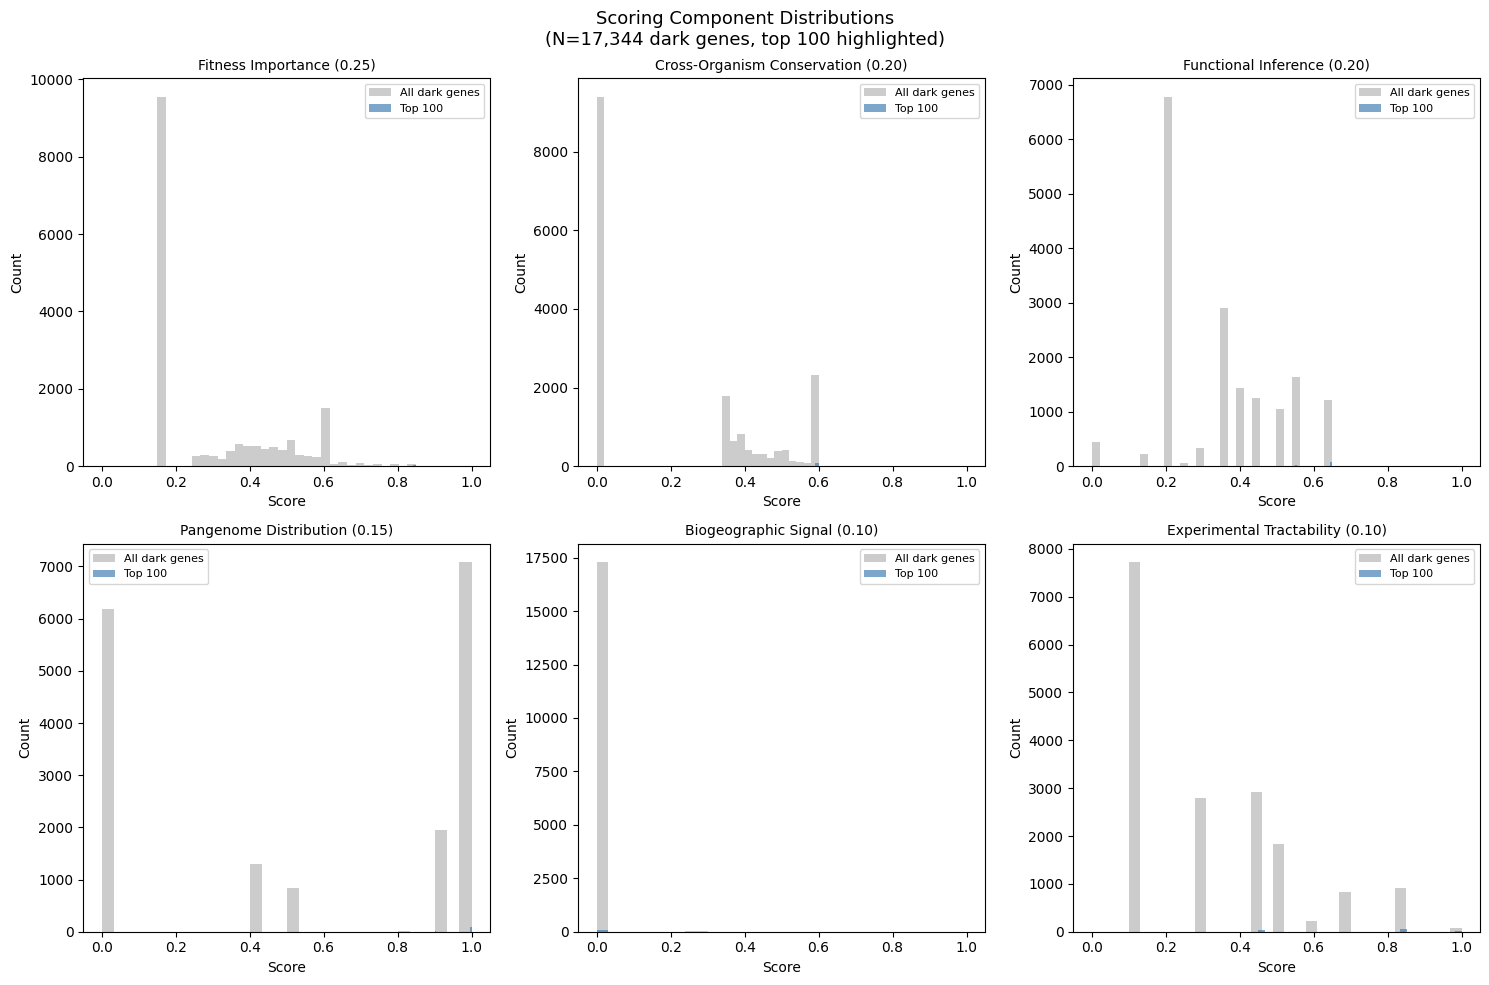

Saved fig13_score_components.png


In [12]:
# Figure 13: Score component breakdown
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

component_names = {
    's_fitness': 'Fitness Importance (0.25)',
    's_conservation': 'Cross-Organism Conservation (0.20)',
    's_inference': 'Functional Inference (0.20)',
    's_pangenome': 'Pangenome Distribution (0.15)',
    's_biogeographic': 'Biogeographic Signal (0.10)',
    's_tractability': 'Experimental Tractability (0.10)',
}

for ax, (col, name) in zip(axes.flat, component_names.items()):
    # All genes in gray, top 100 in color
    ax.hist(scores_df[col], bins=30, alpha=0.4, color='gray', label='All dark genes')
    ax.hist(top100[col], bins=30, alpha=0.7, color='steelblue', label='Top 100')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xlim(-0.05, 1.05)

plt.suptitle(f'Scoring Component Distributions\n(N={len(scores_df):,} dark genes, top 100 highlighted)',
             fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig13_score_components.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig13_score_components.png')

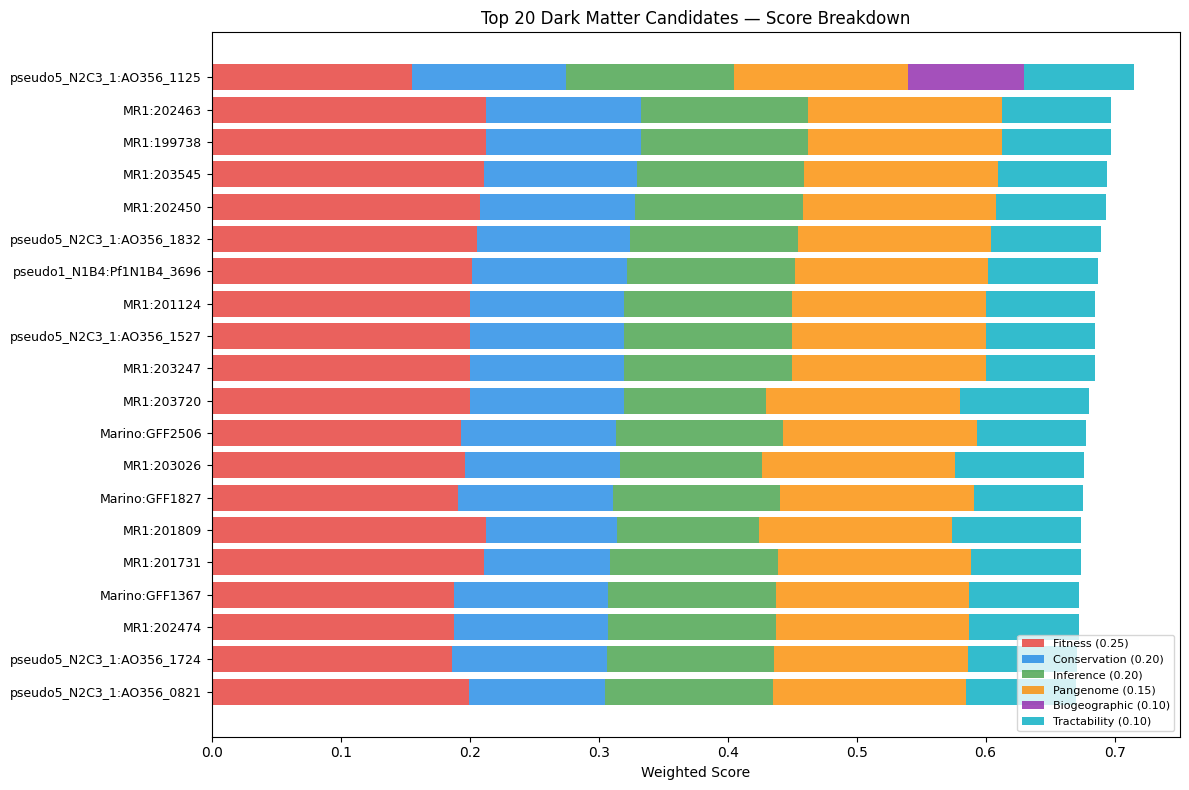

Saved fig14_top20_dossiers.png


In [13]:
# Figure 14: Top 20 candidate dossier summary (stacked bar)
fig, ax = plt.subplots(figsize=(12, 8))

top20 = top100.head(20).copy()
labels = [f'{row["orgId"]}:{row["locusId"]}' for _, row in top20.iterrows()]
# Truncate long labels
labels = [l[:25] for l in labels]

y_pos = np.arange(len(top20))
colors = ['#E53935', '#1E88E5', '#43A047', '#FB8C00', '#8E24AA', '#00ACC1']
component_keys = ['s_fitness', 's_conservation', 's_inference', 's_pangenome',
                  's_biogeographic', 's_tractability']
component_labels = ['Fitness', 'Conservation', 'Inference', 'Pangenome',
                    'Biogeographic', 'Tractability']

left = np.zeros(len(top20))
for i, (key, label) in enumerate(zip(component_keys, component_labels)):
    vals = top20[key].values * list(WEIGHTS.values())[i]
    ax.barh(y_pos, vals, left=left, color=colors[i], label=f'{label} ({list(WEIGHTS.values())[i]:.2f})',
            alpha=0.8)
    left += vals

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Weighted Score')
ax.set_title('Top 20 Dark Matter Candidates — Score Breakdown')
ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig14_top20_dossiers.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig14_top20_dossiers.png')

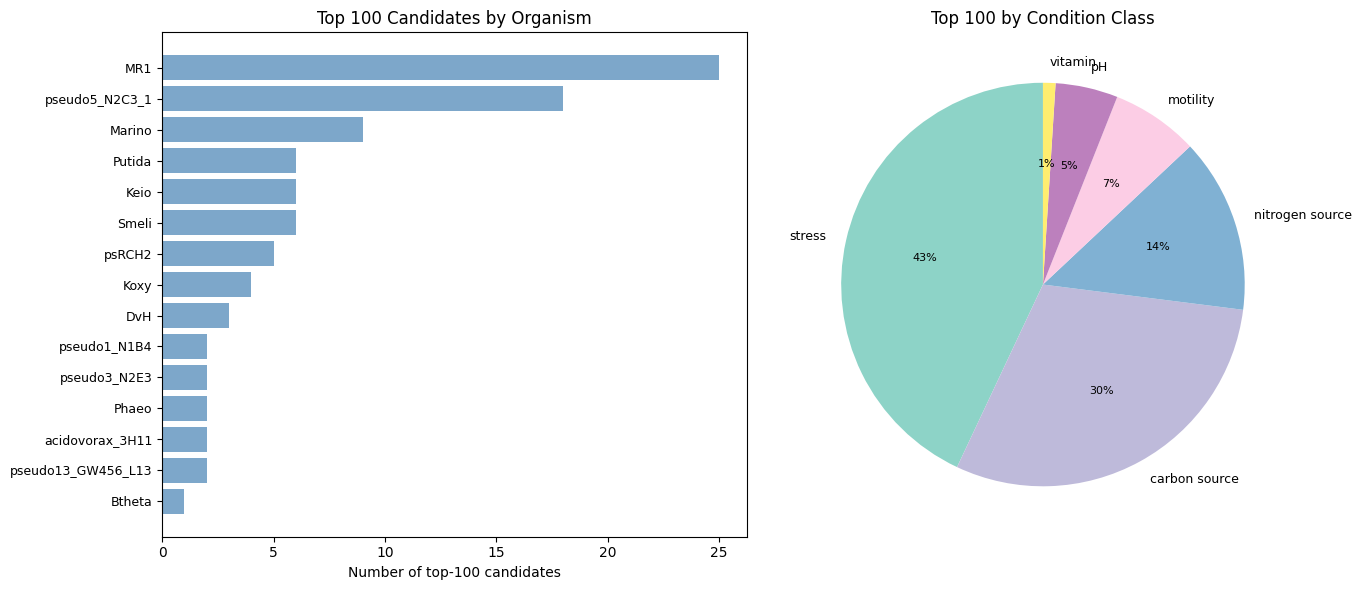

Saved fig15_organism_distribution.png


In [14]:
# Figure 15: Organism distribution and condition class breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Organism distribution of top 100
ax = axes[0]
org_counts = top100['orgId'].value_counts().head(15)
y_pos = range(len(org_counts))
ax.barh(y_pos, org_counts.values, color='steelblue', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(org_counts.index, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of top-100 candidates')
ax.set_title('Top 100 Candidates by Organism')

# Panel B: Condition class pie chart
ax = axes[1]
cond_counts = top100['top_condition_class'].fillna('unknown').value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(cond_counts)))
wedges, texts, autotexts = ax.pie(cond_counts.values, labels=cond_counts.index,
                                   autopct='%1.0f%%', colors=colors_pie, startangle=90)
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_fontsize(8)
ax.set_title('Top 100 by Condition Class')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig15_organism_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig15_organism_distribution.png')

## Section 6: Save Outputs & Summary

In [15]:
# Save top 100 candidates
top100.to_csv(os.path.join(DATA_DIR, 'prioritized_candidates.tsv'), sep='\t', index=False)
print(f'Saved prioritized_candidates.tsv: {len(top100)} candidates')

# Save all scores
scores_df.to_csv(os.path.join(DATA_DIR, 'scoring_all_dark.tsv'), sep='\t', index=False)
print(f'Saved scoring_all_dark.tsv: {len(scores_df):,} genes')

Saved prioritized_candidates.tsv: 100 candidates
Saved scoring_all_dark.tsv: 17,344 genes


In [16]:
# Project-wide summary statistics
print('=' * 70)
print('NB05: PRIORITIZATION & CANDIDATE DOSSIERS — SUMMARY')
print('=' * 70)

print(f'\n--- Scoring ---')
print(f'Genes scored: {len(scores_df):,} (strong fitness + essential dark)')
print(f'Scoring dimensions: 6 (fitness, conservation, inference, pangenome, biogeographic, tractability)')
print(f'Score range: {scores_df["total_score"].min():.3f} – {scores_df["total_score"].max():.3f}')

print(f'\n--- Top 100 Candidates ---')
print(f'Score range: {top100["total_score"].min():.3f} – {top100["total_score"].max():.3f}')
print(f'Organisms: {top100["orgId"].nunique()}')
print(f'Essential: {(top100["is_essential_dark"] == True).sum()}')
print(f'With module prediction: {top100["module_prediction"].notna().sum() - (top100["module_prediction"] == "").sum()}')
print(f'With domains: {(top100["n_domains"].fillna(0).astype(int) > 0).sum()}')

print(f'\nHypothesis confidence:')
print(top100['hypothesis_confidence'].value_counts().to_string())

print(f'\n--- Project-Wide Dark Gene Statistics ---')
all_dark = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_only.tsv'), sep='\t', low_memory=False)
print(f'Total dark genes: {len(all_dark):,}')
print(f'  With pangenome link: {all_dark["has_pangenome_link"].sum():,}')
print(f'  In module: {(all_dark["in_module"] == True).sum():,}')
print(f'  With strong fitness: {(all_dark["max_abs_fit"].astype(float) >= 2.0).sum():,}')
print(f'  Essential: {(all_dark["is_essential_dark"] == True).sum():,}')

print(f'\nOutput files:')
for f in ['prioritized_candidates.tsv', 'scoring_all_dark.tsv']:
    fp = os.path.join(DATA_DIR, f)
    if os.path.exists(fp):
        size_kb = os.path.getsize(fp) / 1024
        print(f'  {f}: {size_kb:.1f} KB')
print(f'\nFigures:')
for f in ['fig13_score_components.png', 'fig14_top20_dossiers.png', 'fig15_organism_distribution.png']:
    fp = os.path.join(FIG_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}')

NB05: PRIORITIZATION & CANDIDATE DOSSIERS — SUMMARY

--- Scoring ---
Genes scored: 17,344 (strong fitness + essential dark)
Scoring dimensions: 6 (fitness, conservation, inference, pangenome, biogeographic, tractability)
Score range: 0.048 – 0.715

--- Top 100 Candidates ---
Score range: 0.624 – 0.715
Organisms: 22
Essential: 0
With module prediction: 85
With domains: 97

Hypothesis confidence:
hypothesis_confidence
high      82
medium    18

--- Project-Wide Dark Gene Statistics ---


Total dark genes: 57,011
  With pangenome link: 39,532
  In module: 6,142
  With strong fitness: 7,787
  Essential: 9,557

Output files:
  prioritized_candidates.tsv: 81.8 KB
  scoring_all_dark.tsv: 3567.9 KB

Figures:
  fig13_score_components.png
  fig14_top20_dossiers.png
  fig15_organism_distribution.png


## Scoring Robustness Check

Test whether the top-ranked fitness-active dark gene candidates are sensitive to arbitrary weight choices by re-scoring under 6 alternative weight configurations and measuring rank stability.

In [17]:
# Scoring sensitivity analysis for NB05 fitness-active dark gene prioritization
from scipy.stats import spearmanr

# Load scored data
scored = pd.read_csv(os.path.join(DATA_DIR, 'scoring_all_dark.tsv'), sep='\t')

# Weight configurations to test (6 dimensions)
weight_configs = {
    'original': {'fitness': 0.25, 'conservation': 0.20, 'inference': 0.20, 'pangenome': 0.15, 'biogeographic': 0.10, 'tractability': 0.10},
    'equal': {'fitness': 1/6, 'conservation': 1/6, 'inference': 1/6, 'pangenome': 1/6, 'biogeographic': 1/6, 'tractability': 1/6},
    'fitness_dominant': {'fitness': 0.40, 'conservation': 0.12, 'inference': 0.12, 'pangenome': 0.12, 'biogeographic': 0.12, 'tractability': 0.12},
    'conservation_dominant': {'fitness': 0.12, 'conservation': 0.40, 'inference': 0.12, 'pangenome': 0.12, 'biogeographic': 0.12, 'tractability': 0.12},
    'drop_biogeographic': {'fitness': 0.27, 'conservation': 0.22, 'inference': 0.22, 'pangenome': 0.17, 'biogeographic': 0.0, 'tractability': 0.12},
    'drop_tractability': {'fitness': 0.28, 'conservation': 0.22, 'inference': 0.22, 'pangenome': 0.17, 'biogeographic': 0.11, 'tractability': 0.0},
}

# Original ranking
original_rank = scored['total_score'].rank(ascending=False).values
original_top50 = set(scored.nlargest(50, 'total_score').index)
original_top100 = set(scored.nlargest(100, 'total_score').index)

results = []
for config_name, weights in weight_configs.items():
    # Compute new total score
    new_score = sum(scored[f's_{dim}'] * w for dim, w in weights.items())
    new_rank = new_score.rank(ascending=False).values
    
    # Spearman rank correlation with original
    rho, p = spearmanr(original_rank, new_rank)
    
    # Top-50 and top-100 overlap
    new_top50 = set(new_score.nlargest(50).index)
    new_top100 = set(new_score.nlargest(100).index)
    overlap_50 = len(original_top50 & new_top50)
    overlap_100 = len(original_top100 & new_top100)
    
    results.append({
        'config': config_name,
        'spearman_rho': rho,
        'spearman_p': p,
        'top50_overlap': overlap_50,
        'top50_pct': 100 * overlap_50 / 50,
        'top100_overlap': overlap_100,
        'top100_pct': 100 * overlap_100 / 100,
        'weights': str(weights),
    })

sensitivity_nb05 = pd.DataFrame(results)
print('NB05 Fitness-Active Scoring Sensitivity Analysis')
print('=' * 70)
for _, row in sensitivity_nb05.iterrows():
    print(f'  {row["config"]:25s}  rho={row["spearman_rho"]:.4f}  '
          f'top-50={row["top50_overlap"]}/50 ({row["top50_pct"]:.0f}%)  '
          f'top-100={row["top100_overlap"]}/100 ({row["top100_pct"]:.0f}%)')

# Summary statistics
non_original = sensitivity_nb05[sensitivity_nb05['config'] != 'original']
min_rho = non_original['spearman_rho'].min()
mean_rho = non_original['spearman_rho'].mean()
min_overlap_50 = non_original['top50_overlap'].min()
min_overlap_100 = non_original['top100_overlap'].min()

print(f'\nAcross 5 alternative configurations:')
print(f'  Rank correlation range: {min_rho:.4f} – {non_original["spearman_rho"].max():.4f} (mean={mean_rho:.4f})')
print(f'  Top-50 overlap range: {min_overlap_50}/50 – {non_original["top50_overlap"].max()}/50')
print(f'  Top-100 overlap range: {min_overlap_100}/100 – {non_original["top100_overlap"].max()}/100')

if min_rho > 0.95 and min_overlap_50 >= 45:
    print(f'\n  ROBUST: Rankings stable under all weight perturbations')
elif min_rho > 0.85 and min_overlap_50 >= 35:
    print(f'\n  MODERATELY ROBUST: Rankings mostly stable')
else:
    print(f'\n  FRAGILE: Rankings sensitive to weight choices — report as limitation')

# Save
sensitivity_nb05.to_csv(os.path.join(DATA_DIR, 'scoring_sensitivity_nb05.tsv'), sep='\t', index=False)
print(f'\nSaved scoring_sensitivity_nb05.tsv')

NB05 Fitness-Active Scoring Sensitivity Analysis
  original                   rho=1.0000  top-50=50/50 (100%)  top-100=100/100 (100%)
  equal                      rho=0.9936  top-50=40/50 (80%)  top-100=73/100 (73%)
  fitness_dominant           rho=0.9676  top-50=40/50 (80%)  top-100=81/100 (81%)
  conservation_dominant      rho=0.9515  top-50=33/50 (66%)  top-100=55/100 (55%)
  drop_biogeographic         rho=0.9998  top-50=45/50 (90%)  top-100=95/100 (95%)
  drop_tractability          rho=0.9893  top-50=33/50 (66%)  top-100=69/100 (69%)

Across 5 alternative configurations:
  Rank correlation range: 0.9515 – 0.9998 (mean=0.9804)
  Top-50 overlap range: 33/50 – 45/50
  Top-100 overlap range: 55/100 – 95/100

  FRAGILE: Rankings sensitive to weight choices — report as limitation

Saved scoring_sensitivity_nb05.tsv
